# Twitter Sentiment Analysis

A Twitter (now X) sentiment analysis determines negative, positive, or neutral emotions within the text of a tweet using NLP and ML models. Sentiment analysis or opinion mining refers to identifying as well as classifying the sentiments that are expressed in the text source. Tweets are often useful in generating a vast amount of sentiment data upon analysis. These data are useful in understanding the opinion of people on social media for a variety of topics.

We're going to take the following approach:

1. Problem Definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem Definition
In a statement, 
> Develop a sentiment analysis system for X (formerly Twitter) to categorize tweets as negative, positive, or neutral emotions, enabling insights into public opinion on various topics using NLP and ML models.

## 2. Data
We will be using **Sentiment140 dataset** from Kaggle, which consists of 16,00,000 tweets that have been extracted using the Twitter API. 

Link to the dataset: https://www.kaggle.com/datasets/kazanova/sentiment140

## 3. Evaluation
The effectiveness of the sentiment analysis system will be assessed based on its accuracy in classifying tweets into negative, positive, or neutral categories, its ability to handle large volumes of real-time data from X (formerly Twitter), and its capacity to provide actionable insights into public opinion on diverse topics.

## 4. Features
This is where you will get information about each feature in the data.

* **target:** the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)<br>
* **ids:** Unique id of the tweet (2087)<br>
* **date:** the date of the tweet (Sat May 16 23:58:44 UTC 2009)<br>
* **flag:** It refers to the query. If no such query exists, then it is NO QUERY.<br>
* **user:** It refers to the name of the user that tweeted (robotickilldozr)<br>
* **text:** It refers to the text of the tweet (Lyx is cool)

#### Preparing the tools

In [1]:
# utilities
import re #regex
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer #Lemmatization is the process of reducing the word (running -> run, cats-> cat)

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

#### Reading and Loading the dataset

In [2]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv("data/twitter-dataset.csv", encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

#### Exploratory Data Analysis (EDA)

In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [5]:
print(f"Length of dataset is {len(df)}")

Length of dataset is 1600000


In [6]:
df.shape

(1600000, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [9]:
df['target'].unique()

array([0, 4], dtype=int64)

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

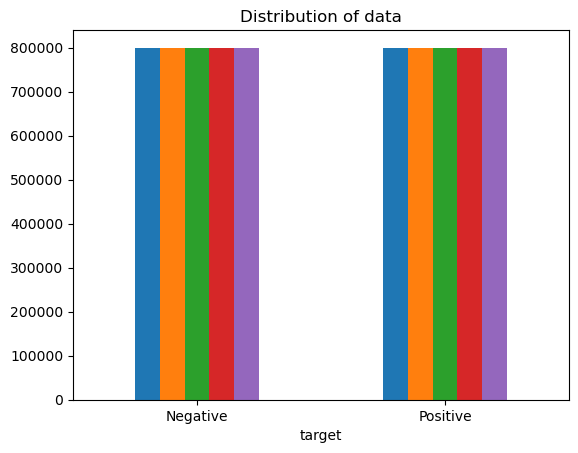

In [10]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [11]:
# Storing data in lists.
text = list(df['text'])
sentiment = list(df['target'])

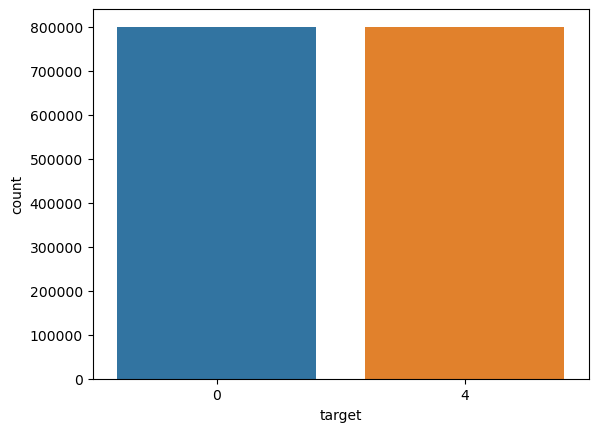

In [12]:
sns.countplot(x='target', data=df);

#### Data preprocessing

In [13]:
data=df[['text','target']]

In [14]:
data.tail(5)

,text,target
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4
1599999,happy #charitytuesday @theNSPCC @SparksCharity...,4


In [15]:
# Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)
data['target'] = data['target'].replace(4,1)

C:\Users\Samla\AppData\Local\Temp\ipykernel_4768\1081914997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [16]:
data['target'].unique()

array([0, 1], dtype=int64)

In [17]:
pos_data = data[data['target'] == 1]
neg_data = data[data['target'] == 0]

In [18]:
# Using 1/4th data
pos_data = pos_data.iloc[:int(20000)]
neg_data = neg_data.iloc[:int(20000)]

In [19]:
dataset = pd.concat([pos_data, neg_data])

In [20]:
# Making text to lower case
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [21]:
# Defining set containing all stopwords in English.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 
             'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [22]:
# Cleaning and removing the above stop words list from the tweets
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [23]:
# Cleaning and removing punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [24]:
# Cleaning and removing repeating character
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [25]:
# Cleaning and removing URLs
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [26]:
# Cleaning and removing numeric numbers
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [27]:
# Tokenization of tweet text
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [28]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [29]:
# Applying lemmatizer
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

#### Splitting into X and y

In [30]:
X=data.text
y=data.target

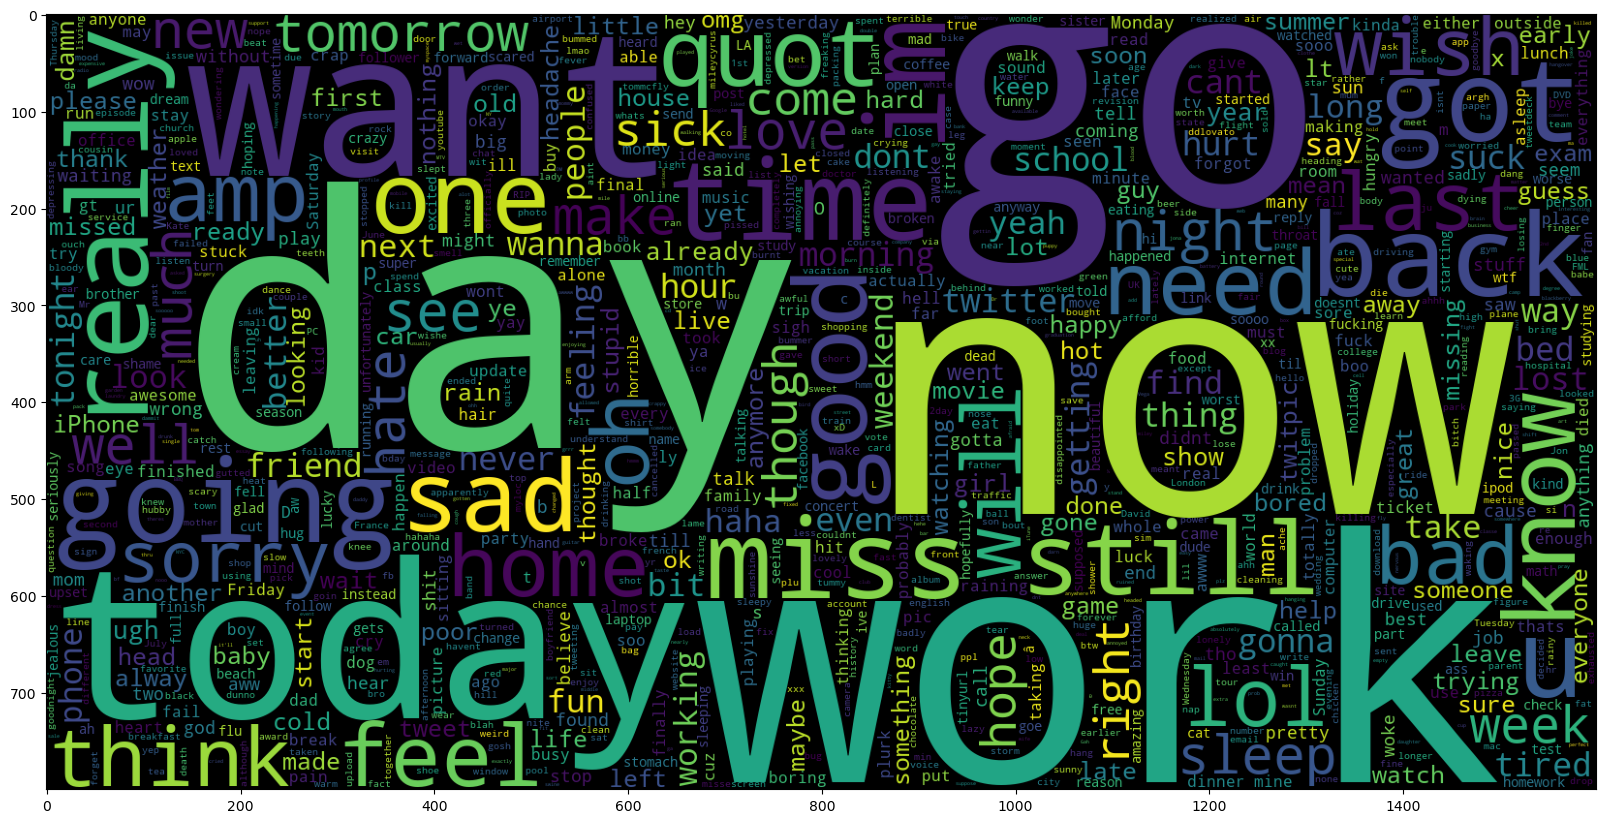

In [31]:
# WordCloud for negative tweets
neg_data = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(neg_data))
plt.imshow(wc);

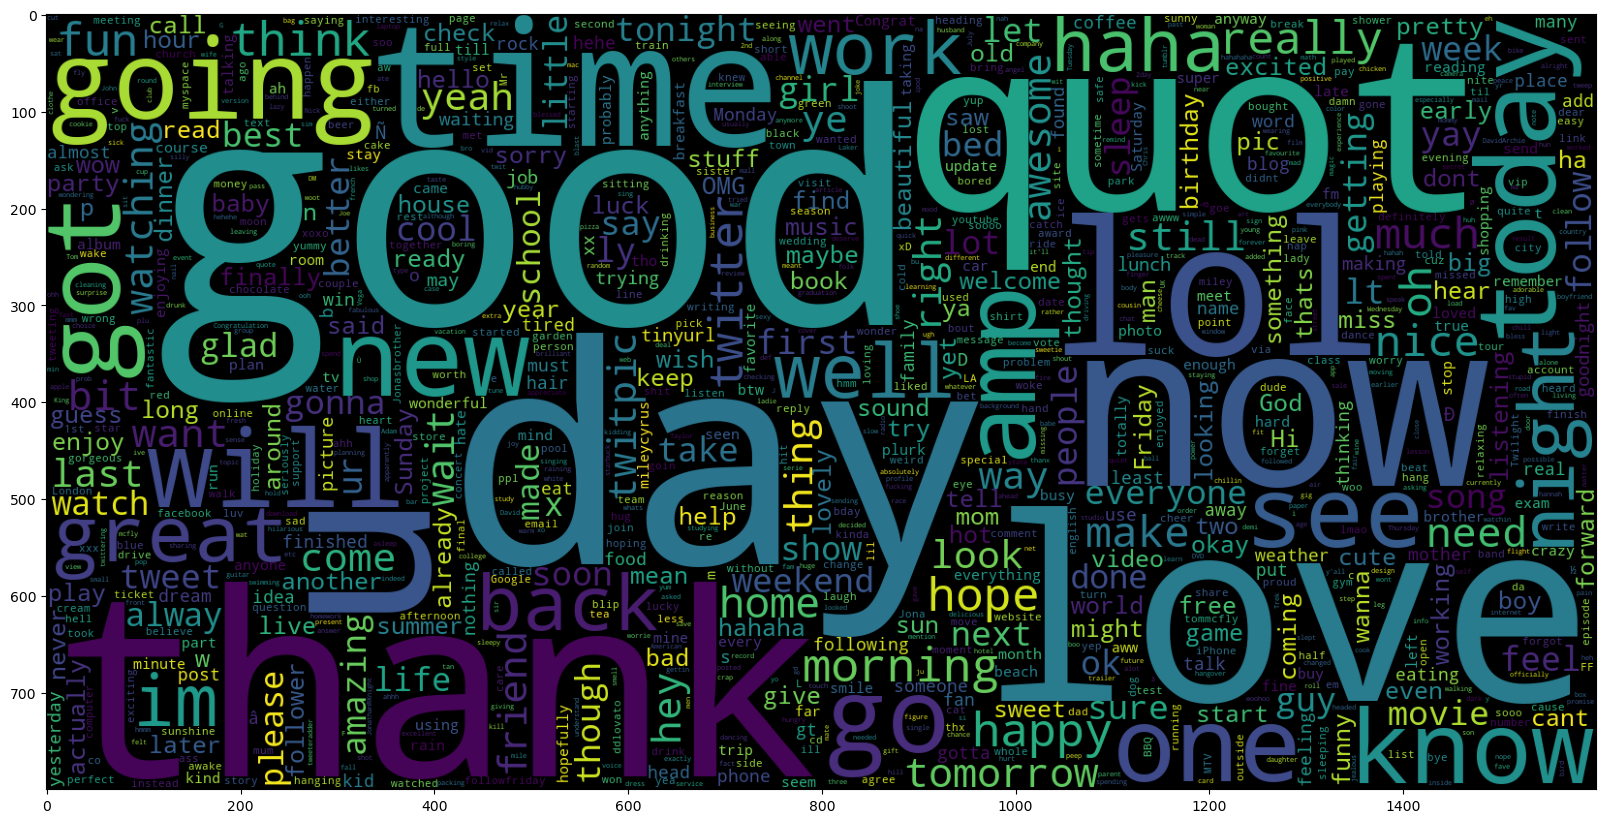

In [32]:
# WordCloud for positive tweets
pos_data = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(pos_data))
plt.figure(figsize = (20,20))
plt.imshow(wc);

## 5. Modelling:
#### 95% data for training data and 5% for testing data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.05,
                                                    random_state =42)

In [34]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.vocabulary_))

No. of feature_words:  500000


In [36]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

We will evaluate our models using these evaluation techniques:
* Accuracy Score
* Confusion Matrix with Plot
*  ROC-AUC Curve

In [48]:
def model_Evaluate(model):
    
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Models
We will be using 3 models to test our sentiment analysis model:

1. Bernoulli Naive Bayes Classifier
2. SVM (Support Vector Machine)
3. Logistic Regression

#### 5.1 Bernoulli Naive Bayes Classifier

In [49]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

BernoulliNB()

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39999
           1       0.80      0.81      0.80     40001

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



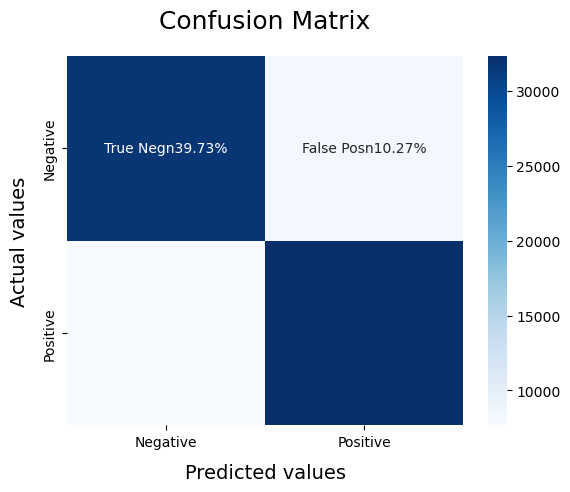

In [50]:
model_Evaluate(BNBmodel)

In [53]:
y_pred1 = BNBmodel.predict(X_test)

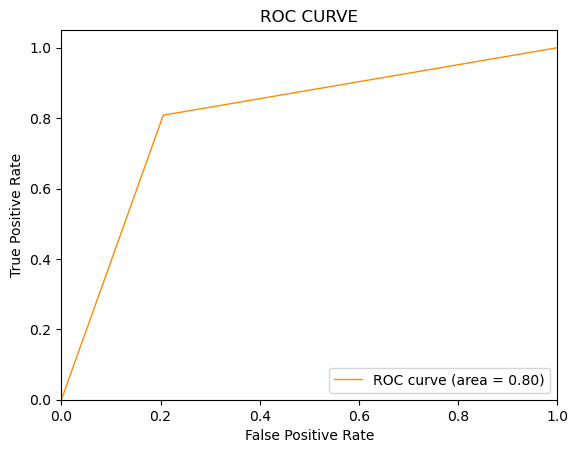

In [54]:
# Plotting the ROC-AUC Curve for model-1

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### 5.2 SVM (Support Vector Machine)

In [55]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

LinearSVC()

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39999
           1       0.81      0.82      0.82     40001

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



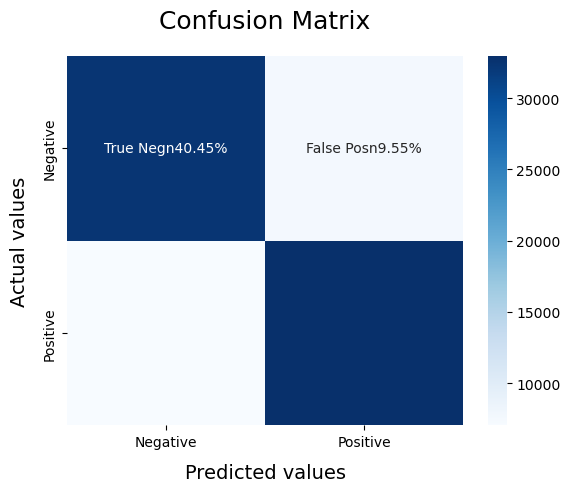

In [56]:
model_Evaluate(SVCmodel)

In [57]:
y_pred2 = SVCmodel.predict(X_test)

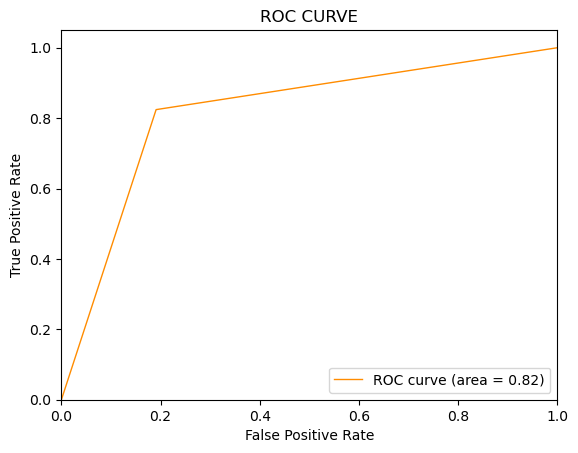

In [58]:
# Plotting the ROC-AUC Curve for model-2

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

#### 5.3 Logistic Regression

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

In [ ]:
model_Evaluate(LRmodel)

In [ ]:
y_pred3 = LRmodel.predict(X_test)

In [ ]:
# Plotting the ROC-AUC Curve for model-3

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()